## This script tests for significantly different relative abundances of genes (KOs) or gene categories between two groups using metagenome read counts, normalized by metagenome Genome Equivalent value and mapped to each gene. A t-test is used to test for significant difference and genes with a p-value below a certain threshold are displayed in a heat map.

In [21]:
import os as os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels
from statsmodels.stats.multitest import fdrcorrection

## Import file of KOs, associated categories, and normalized read counts

In [94]:
os.chdir('/Users/npatin3/Desktop/GTPostdoc/Noro_Assemblies/Asymp_vs_symp')
path = "Asymp_vs_symp_KOs_readcounts.txt"

In [97]:
kos = pd.read_csv(path, header=0, sep=',')
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism [PATH:ko00051],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism [PATH:ko00052],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism [PATH:ko00500],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism [P...,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [98]:
# Split out the "PATH" part of Subgroup2 label
kos[['Subgroup2', 'PATH']] = kos['Subgroup2'].str.split("[", n=1, expand=True)
kos = kos.drop('PATH', axis=1)
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [99]:
# Exclude irrelevant categories
kos2 = kos.loc[(kos['Group'] != 'Human Diseases') & 
               (kos['Group'] != 'Brite Hierarchies') & 
               (kos['Group'] != 'Organismal Systems') &
               (kos['Subgroup'] != 'Cellular community - eukaryotes')]

In [100]:
kos.size

235930

In [101]:
kos2.size

146530

## Pull out only level of interest, ie KOs or Subgroups2

In [102]:
df = kos2[['KO','Sample','ReadCounts_Norm', 'dataset']]
df.head()

,KO,Sample,ReadCounts_Norm,dataset
0,K00844,13_1,0.001825,Asymptomatic
1,K00844,13_1,0.001825,Asymptomatic
2,K00844,13_1,0.001825,Asymptomatic
3,K00844,13_1,0.001825,Asymptomatic
4,K00844,13_1,0.001825,Asymptomatic


### For KOs only, drop duplicates within each sample

In [103]:
df2 = df.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df2.head()

,KO,Sample,ReadCounts_Norm,dataset
8696,K07720,28_1,0.001192,Asymptomatic
17769,K00791,4_1,0.001192,Symptomatic
17745,K03526,15_1,0.001192,Symptomatic
17742,K00919,4_1,0.001192,Symptomatic
17739,K00919,15_1,0.001192,Symptomatic


## Run t-tests and fold-difference calculations on KOs or categories

#### Reformat data frame

In [122]:
df3 = pd.pivot_table(data=df, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3 = df3.reindex(['4_1','15_1','36_1','37_1','13_1','28_1','38_1','41_1','49_1']).fillna(0)
df3.head()

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.0,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.0,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.0,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.0,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.0,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000


### T-test on each gene between asymptomatic and symptomatic groups

#### Add new empty rows for statistical results

In [123]:
df4 = df3.append(pd.Series(name='ttest'))
df4 = df4.append(pd.Series(name='p-value'))
df4 = df4.append(pd.Series(name='corrected_p-value'))
df4 = df4.append(pd.Series(name='fold difference'))
df4

/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series 

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.000000,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.000000,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.000000,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.000000,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.000000,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000
28_1,0.000000,0.001192,0.000000,0.002384,0.000000,0.000000,0.009535,0.000000,0.000000,0.000000,...,0.001192,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.002384
38_1,0.004386,0.006579,0.000000,0.000000,0.000000,0.017544,0.004386,0.000000,0.000000,0.004386,...,0.000000,0.002193,0.000000,0.000000,0.000000,0.000000,0.002193,0.000000,0.000000,0.004386
41_1,0.004373,0.000000,0.000000,0.001458,0.001458,0.013120,0.017493,0.011662,0.000000,0.002915,...,0.000000,0.001458,0.001458,0.000000,0.001458,0.002915,0.008746,0.000000,0.001458,0.002915
49_1,0.003082,0.000000,0.000000,0.000000,0.000000,0.009245,0.004622,0.004622,0.001541,0.010786,...,0.000000,0.006163,0.000000,0.000000,0.000000,0.006163,0.001541,0.000000,0.000000,0.000000


#### Fill new rows with results of scipy stats ttest and statsmodels Benjamini/Hochberg multitest correction

In [124]:
df4.iloc[9] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=True))[0]
df4.iloc[10] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=True))[1]
df4.iloc[11] = fdrcorrection(df4.iloc[10], alpha=0.1, method='indep')[1]
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.000000,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.000000,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.000000,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.000000,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.000000,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000
28_1,0.000000,0.001192,0.000000,0.002384,0.000000,0.000000,0.009535,0.000000,0.000000,0.000000,...,0.001192,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.002384
38_1,0.004386,0.006579,0.000000,0.000000,0.000000,0.017544,0.004386,0.000000,0.000000,0.004386,...,0.000000,0.002193,0.000000,0.000000,0.000000,0.000000,0.002193,0.000000,0.000000,0.004386
41_1,0.004373,0.000000,0.000000,0.001458,0.001458,0.013120,0.017493,0.011662,0.000000,0.002915,...,0.000000,0.001458,0.001458,0.000000,0.001458,0.002915,0.008746,0.000000,0.001458,0.002915
49_1,0.003082,0.000000,0.000000,0.000000,0.000000,0.009245,0.004622,0.004622,0.001541,0.010786,...,0.000000,0.006163,0.000000,0.000000,0.000000,0.006163,0.001541,0.000000,0.000000,0.000000


### Function to calculate fold difference between asymptomatic and symptomatic samples

In [71]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

### Apply function to data frame to calculate fold difference of each column

In [125]:
df4 = df4.replace(0, 0.000000001)
df4.loc['fold difference'] = fold_difference(df4, 4, 9)
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,5.282129e-03,3.649635e-03,1.457726e-02,1.000000e-09,2.372897e-03,...,1.000000e-09,1.641272e-03,1.000000e-09,5.830904e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.622496e-03,1.000000e-09
15_1,4.390448e-03,1.000000e-09,3.333174e-03,4.385965e-03,1.392831e-02,7.541524e-03,2.192982e-03,3.081664e-03,1.327726e-02,5.016962e-03,...,1.000000e-09,1.641272e-03,3.282543e-03,9.124088e-03,3.081664e-03,1.000000e-09,4.385965e-03,1.000000e-09,3.575685e-03,3.081664e-03
36_1,7.980008e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,7.162877e-03,3.081664e-03,2.383790e-03,1.327726e-02,5.498608e-03,...,1.000000e-09,3.040111e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.457726e-03,1.824818e-03,1.000000e-09,4.767580e-03
37_1,9.613080e-03,1.641272e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.042022e-03,3.575685e-03,3.649635e-03,1.000000e-09,2.854544e-03,...,1.000000e-09,3.223657e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.385965e-03,1.540832e-03,1.824818e-03,4.767580e-03
13_1,1.824818e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.474453e-03,1.824818e-02,1.000000e-09,7.299270e-03,1.000000e-09,3.649635e-03,...,1.000000e-09,3.649635e-03,3.649635e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.000000e-09
28_1,1.000000e-09,1.191895e-03,1.000000e-09,2.383790e-03,1.000000e-09,1.000000e-09,9.535161e-03,1.000000e-09,1.000000e-09,1.000000e-09,...,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,2.383790e-03
38_1,4.385965e-03,6.578947e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.754386e-02,4.385965e-03,1.000000e-09,1.000000e-09,4.385965e-03,...,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,4.385965e-03
41_1,4.373178e-03,1.000000e-09,1.000000e-09,1.457726e-03,1.457726e-03,1.311953e-02,1.749271e-02,1.166181e-02,1.000000e-09,2.915452e-03,...,1.000000e-09,1.457726e-03,1.457726e-03,1.000000e-09,1.457726e-03,2.915452e-03,8.746356e-03,1.000000e-09,1.457726e-03,2.915452e-03
49_1,3.081664e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,9.244992e-03,4.622496e-03,4.622496e-03,1.540832e-03,1.078582e-02,...,1.000000e-09,6.163328e-03,1.000000e-09,1.000000e-09,1.000000e-09,6.163328e-03,1.540832e-03,1.000000e-09,1.000000e-09,1.000000e-09


### Select columns where corrected p-value row (row 11) is less than 0.05

In [126]:
kos_significant = df4.loc[:, df4.iloc[11] < 0.05]
kos_significant

KO,K00761,K00806,K00925,K00975,K01223,K01480,K01652,K01676,K01738,K01803,...,K03654,K03787,K04487,K04517,K04720,K06400,K07133,K11358,K15771,K20487
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,7.288630e-03,0.028509,0.062960,2.139501e-01,2.737392e-02,4.622496e-03,3.075646e-02,0.001397,0.016498,1.185421e-02,...,0.004386,0.016459,2.261070e-02,1.277372e-02,3.694875e-02,0.559322,0.001541,1.219307e-02,1.232666e-02,1.341663e-02
15_1,1.457726e-02,0.027414,0.044562,1.338951e-01,1.373618e-02,2.383790e-03,3.551163e-02,0.001397,0.017870,9.878266e-03,...,0.001192,0.013137,1.655494e-02,6.559767e-03,7.871720e-02,0.507299,0.011662,8.371449e-03,1.642336e-02,2.206008e-02
36_1,1.535088e-02,0.023723,0.060209,1.273535e-01,2.020458e-02,3.649635e-03,3.433007e-02,0.001397,0.015325,1.669739e-02,...,0.001825,0.018316,2.206008e-02,1.425439e-02,5.482456e-02,0.800292,0.003082,7.835480e-03,2.623907e-02,1.933085e-02
37_1,7.704160e-03,0.036443,0.060272,1.909417e-01,2.498085e-02,4.373178e-03,3.024019e-02,0.001397,0.018906,1.345587e-02,...,0.004373,0.019460,3.029576e-02,1.386749e-02,4.622496e-02,0.625000,0.007299,9.208409e-03,1.315789e-02,1.472745e-02
13_1,1.000000e-09,0.001825,0.010949,1.000000e-09,1.000000e-09,1.000000e-09,1.824818e-03,0.009124,0.003650,1.824818e-03,...,0.014599,0.005474,3.649635e-03,1.000000e-09,1.000000e-09,0.025547,0.047445,1.000000e-09,1.000000e-09,1.000000e-09
28_1,1.000000e-09,0.002384,0.004768,2.383790e-03,1.191895e-03,1.191895e-03,1.000000e-09,0.013111,0.002384,1.000000e-09,...,0.010727,0.003576,1.000000e-09,2.383790e-03,2.383790e-03,0.003576,0.053635,1.000000e-09,1.000000e-09,1.000000e-09
38_1,1.000000e-09,0.006579,0.006579,4.385965e-03,4.385965e-03,1.000000e-09,1.754386e-02,0.010965,0.008772,4.385965e-03,...,0.013158,0.008772,1.000000e-09,1.000000e-09,4.385965e-03,0.032895,0.054825,1.000000e-09,1.000000e-09,4.385965e-03
41_1,1.000000e-09,0.007289,0.004373,2.915452e-03,1.457726e-03,1.000000e-09,1.166181e-02,0.010204,0.002915,1.000000e-09,...,0.017493,0.007289,1.457726e-03,1.457726e-03,5.830904e-03,0.010204,0.055394,1.000000e-09,1.000000e-09,1.457726e-03
49_1,1.000000e-09,0.003082,0.015408,3.081664e-03,1.000000e-09,1.000000e-09,4.622496e-03,0.012327,0.003082,4.622496e-03,...,0.018490,0.004622,1.540832e-03,1.540832e-03,4.622496e-03,0.007704,0.064715,1.540832e-03,1.000000e-09,1.000000e-09


In [36]:
kos_significant.to_csv("sig_diff_KOs_CORRECTED.csv")

### Make list of significant KOs

In [115]:
ko_list = list(kos_significant)

In [116]:
ko_list

['K00761',
 'K00806',
 'K00925',
 'K00975',
 'K01223',
 'K01480',
 'K01652',
 'K01676',
 'K01738',
 'K01803',
 'K01915',
 'K01995',
 'K01998',
 'K02031',
 'K02038',
 'K02871',
 'K03654',
 'K03787',
 'K04487',
 'K04517',
 'K04720',
 'K06400',
 'K07133',
 'K11358',
 'K15771',
 'K20487']

### Extract rows from original data frame containing any of the significant KOs

In [38]:
mask = kos2['KO'].apply(lambda x: any(item for item in ko_list if item in x))
df = kos2[mask]

In [39]:
df.shape

(463, 10)

In [40]:
df.sort_values(by=['KO'])

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
15714,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K00761,"upp, UPRT; uracil phosphoribosyltransferase [...",1,37_1,554,0.007704,Symptomatic
15712,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K00761,"upp, UPRT; uracil phosphoribosyltransferase [...",2,15_1,984,0.014577,Symptomatic
15713,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K00761,"upp, UPRT; uracil phosphoribosyltransferase [...",1,36_1,738,0.015351,Symptomatic
15715,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K00761,"upp, UPRT; uracil phosphoribosyltransferase [...",1,4_1,752,0.007289,Symptomatic
5943,Metabolism,Metabolism of terpenoids and polyketides,Terpenoid backbone biosynthesis,K00806,uppS; undecaprenyl diphosphate synthase [EC:2...,2,28_1,839,0.002384,Asymptomatic
...,...,...,...,...,...,...,...,...,...,...
20087,Environmental Information Processing,Signal transduction,Two-component system,K20487,"nisK, spaK; two-component system, OmpR family...",1,37_1,554,0.018490,Symptomatic
20086,Environmental Information Processing,Signal transduction,Two-component system,K20487,"nisK, spaK; two-component system, OmpR family...",3,36_1,738,0.010965,Symptomatic
20085,Environmental Information Processing,Signal transduction,Two-component system,K20487,"nisK, spaK; two-component system, OmpR family...",2,15_1,984,0.027697,Symptomatic
8590,Cellular Processes,Cellular community - prokaryotes,Quorum sensing,K20487,"nisK, spaK; two-component system, OmpR family...",1,41_1,686,0.001458,Asymptomatic


In [41]:
df3 = df.drop_duplicates(subset=['KO'])[['KO','Function']]
df3.head()

,KO,Function
246,K01803,"TPI, tpiA; triosephosphate isomerase (TIM) [E..."
724,K01223,"E3.2.1.86B, bglA; 6-phospho-beta-glucosidase ..."
867,K01676,"E4.2.1.2A, fumA, fumB; fumarate hydratase, cl..."
1471,K00975,glgC; glucose-1-phosphate adenylyltransferase...
1849,K00925,ackA; acetate kinase [EC:2.7.2.1]


In [42]:
df3.shape

(26, 2)

In [43]:
df2.to_csv("KOs_significantly_different_all_CORRECTED.csv")

In [44]:
df3.to_csv("KOs_SD_CORRECTED_functions.csv")

## Heat map of just the significantly different genes

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
counts = pd.read_csv(path, header=0)
counts.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism [PATH:ko00051],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism [PATH:ko00052],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism [PATH:ko00500],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism [P...,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [51]:
df = counts.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
11694,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K04096,smf; DNA processing protein,1,28_1,839,0.001192,Asymptomatic
1921,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K07248,aldA; lactaldehyde dehydrogenase / glycolalde...,1,28_1,839,0.001192,Asymptomatic
1916,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K03778,ldhA; D-lactate dehydrogenase [EC:1.1.1.28],1,28_1,839,0.001192,Asymptomatic
11684,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07459,ybjD; putative ATP-dependent endonuclease of ...,1,28_1,839,0.001192,Asymptomatic
11672,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07454,K07454; putative restriction endonuclease,1,28_1,839,0.001192,Asymptomatic


In [52]:
mask = df['KO'].apply(lambda x: any(item for item in ko_list if item in x))
#inverted_mask = mask2!=True
df2 = df[mask]

In [53]:
df2 = df2[['KO','Sample','ReadCounts_Norm','dataset']]
df2.head()

,KO,Sample,ReadCounts_Norm,dataset
18729,K03654,15_1,0.001192,Symptomatic
4436,K01480,28_1,0.001192,Asymptomatic
8132,K01995,28_1,0.001192,Asymptomatic
8123,K01998,28_1,0.001192,Asymptomatic
724,K01223,28_1,0.001192,Asymptomatic


### Format for heat map

In [54]:
df3 = pd.pivot_table(data=df2, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3.fillna(0)
df3.head()

KO,K00761,K00806,K00925,K00975,K01223,K01480,K01652,K01676,K01738,K01803,...,K03654,K03787,K04487,K04517,K04720,K06400,K07133,K11358,K15771,K20487
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.000000,0.001825,0.010949,0.000000,0.000000,0.000000,0.001825,0.009124,0.003650,0.001825,...,0.014599,0.005474,0.003650,0.000000,0.000000,0.025547,0.047445,0.000000,0.000000,0.000000
15_1,0.014577,0.027414,0.092105,0.192982,0.016687,0.002384,0.043732,0.001541,0.018248,0.012774,...,0.001192,0.018248,0.016687,0.008746,0.078717,0.507299,0.011662,0.026316,0.016423,0.027697
28_1,0.000000,0.002384,0.004768,0.002384,0.001192,0.001192,0.000000,0.013111,0.002384,0.000000,...,0.010727,0.003576,0.000000,0.002384,0.002384,0.003576,0.053635,0.000000,0.000000,0.000000
36_1,0.015351,0.023723,0.161808,0.173358,0.023723,0.003650,0.043732,0.001541,0.017493,0.021866,...,0.001825,0.024781,0.027697,0.019737,0.054825,0.800292,0.003082,0.026316,0.026239,0.027697
37_1,0.007704,0.036443,0.161808,0.275510,0.026239,0.004373,0.041667,0.001541,0.024653,0.017544,...,0.004373,0.024781,0.032895,0.013867,0.046225,0.625000,0.007299,0.023324,0.026239,0.021866


In [55]:
# Log transform
df3_log = np.log(df3.replace(0, 0.0000001))
df3_log.head()

KO,K00761,K00806,K00925,K00975,K01223,K01480,K01652,K01676,K01738,K01803,...,K03654,K03787,K04487,K04517,K04720,K06400,K07133,K11358,K15771,K20487
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,-16.118096,-6.306275,-4.514516,-16.118096,-16.118096,-16.118096,-6.306275,-4.696837,-5.613128,-6.306275,...,-4.226834,-5.207663,-5.613128,-16.118096,-16.118096,-3.667218,-3.048179,-16.118096,-16.118096,-16.118096
15_1,-4.228293,-3.596716,-2.384823,-1.645156,-4.093153,-6.039064,-3.129680,-6.475433,-4.003690,-4.360365,...,-6.732211,-4.003690,-4.093153,-4.739118,-2.541894,-0.678654,-4.451436,-3.637586,-4.109051,-3.586439
28_1,-16.118096,-6.039064,-5.345916,-6.039064,-6.732211,-6.732211,-16.118096,-4.334315,-6.039064,-16.118096,...,-4.534986,-5.633598,-16.118096,-6.039064,-6.039064,-5.633598,-2.925548,-16.118096,-16.118096,-16.118096
36_1,-4.176583,-3.741326,-1.821347,-1.752398,-3.741326,-5.613128,-3.129680,-6.475433,-4.045971,-3.822827,...,-6.306275,-3.697664,-3.586439,-3.925268,-2.903617,-0.222779,-5.782286,-3.637586,-3.640506,-3.586439
37_1,-4.865995,-3.312002,-1.821347,-1.289131,-3.640506,-5.432265,-3.178054,-6.475433,-3.702844,-4.043051,...,-5.432265,-3.697664,-3.414443,-4.278208,-3.074235,-0.470004,-4.919981,-3.758289,-3.640506,-3.822827


In [56]:
# Square root transform
df3_sqrt = np.sqrt(df3.replace(0, 0.0000001))
df3_sqrt.head()

KO,K00761,K00806,K00925,K00975,K01223,K01480,K01652,K01676,K01738,K01803,...,K03654,K03787,K04487,K04517,K04720,K06400,K07133,K11358,K15771,K20487
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.000316,0.042718,0.104637,0.000316,0.000316,0.000316,0.042718,0.095520,0.060412,0.042718,...,0.120824,0.073990,0.060412,0.000316,0.000316,0.159836,0.217819,0.000316,0.000316,0.000316
15_1,0.120736,0.165570,0.303488,0.439298,0.129176,0.048824,0.209121,0.039253,0.135086,0.113021,...,0.034524,0.135086,0.129176,0.093522,0.280566,0.712249,0.107990,0.162221,0.128154,0.166424
28_1,0.000316,0.048824,0.069048,0.048824,0.034524,0.034524,0.000316,0.114503,0.048824,0.000316,...,0.103572,0.059797,0.000316,0.048824,0.048824,0.059797,0.231593,0.000316,0.000316,0.000316
36_1,0.123899,0.154022,0.402253,0.416362,0.154022,0.060412,0.209121,0.039253,0.132260,0.147871,...,0.042718,0.157421,0.166424,0.140488,0.234146,0.894590,0.055513,0.162221,0.161985,0.166424
37_1,0.087773,0.190901,0.402253,0.524891,0.161985,0.066130,0.204124,0.039253,0.157014,0.132453,...,0.066130,0.157421,0.181369,0.117760,0.215000,0.790569,0.085436,0.152721,0.161985,0.147871


## Set palette for color bar

In [57]:
my_palette = dict(zip(df2.dataset.unique(), ["purple","orange"]))
row_colors = df.dataset.map(my_palette)
sampz = df.Sample

In [58]:
sample_colors = sampz.to_frame().join(row_colors)
sample_colors = sample_colors.drop_duplicates(subset=['Sample'])
sample_colors = sample_colors.set_index('Sample')
sample_colors.head()

,dataset
Sample,
28_1,orange
15_1,purple
37_1,purple
4_1,purple
36_1,purple


## Make the heatmap

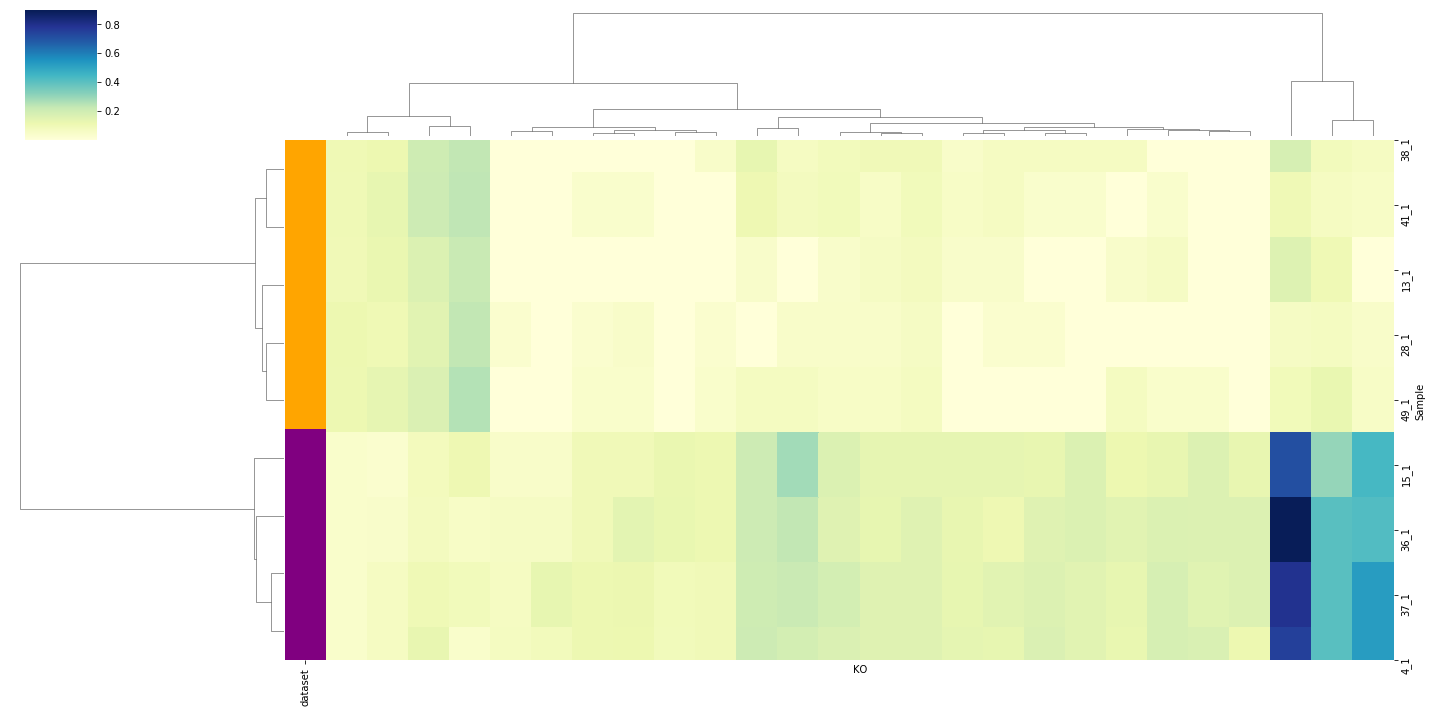

In [59]:
p = sns.clustermap(df3_sqrt, cmap='YlGnBu', figsize=(20,10), xticklabels=False, method='ward', metric='euclidean', row_colors = sample_colors)

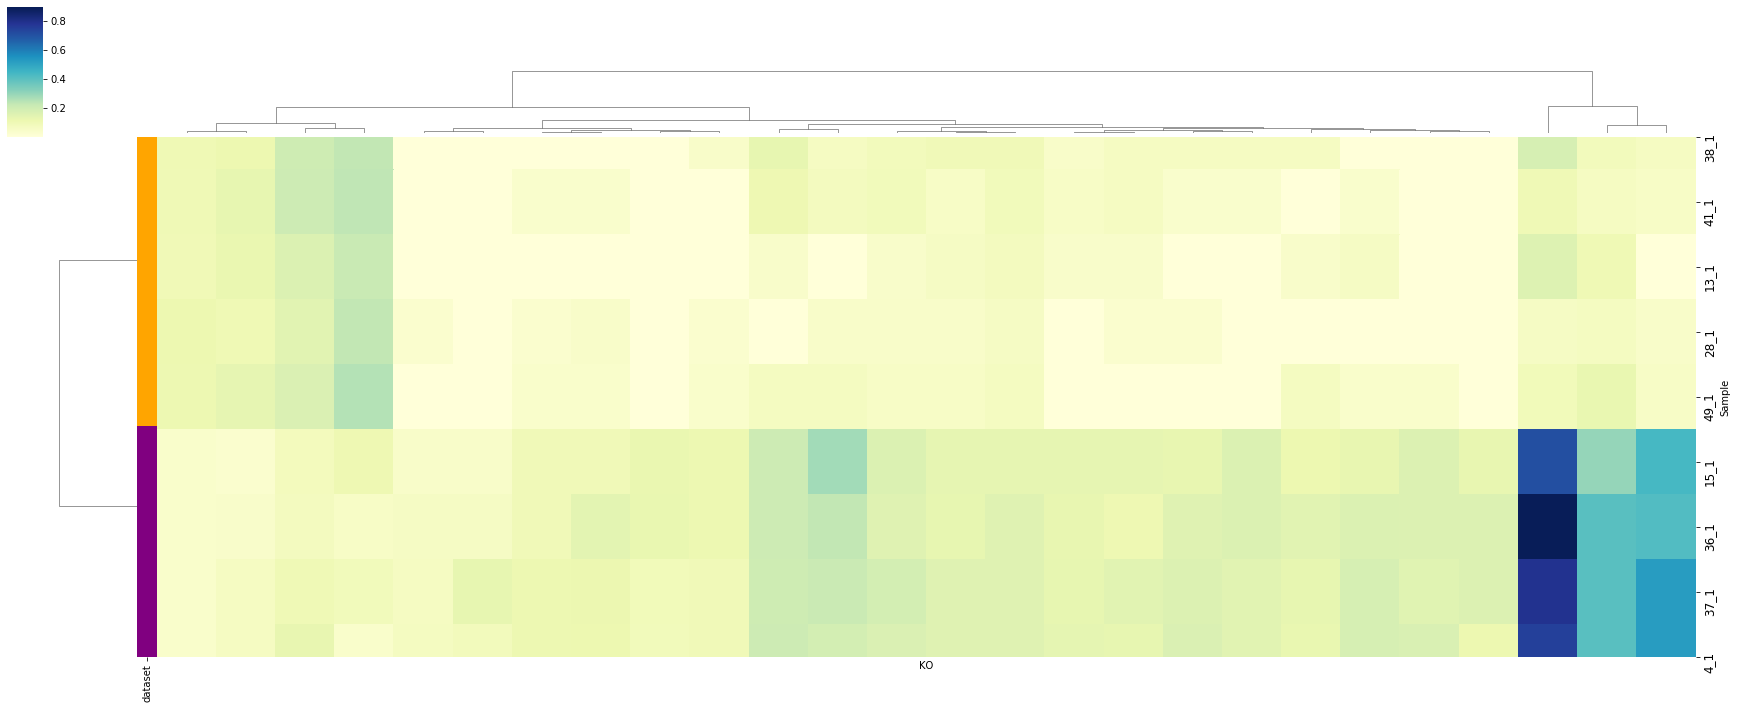

In [60]:
p = sns.clustermap(df3_sqrt, cmap='YlGnBu', method='ward', metric='euclidean', xticklabels=False, row_colors = sample_colors)
hm = p.ax_heatmap.get_position()
plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)
plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), fontsize=18)
p.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*3, hm.height])
col = p.ax_col_dendrogram.get_position()
row = p.ax_row_dendrogram.get_position()
p.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*3, col.height*0.5])
p.ax_row_dendrogram.set_position([row.x0+0.07, row.y0, row.width*0.75, row.height])

In [61]:
p.savefig("All_SD_CORRECTED_KOs_log.png")